In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import pandas as pd
import cv2
from pyproj import Transformer

In [13]:
df = pd.read_csv('./data/lunar_crater_database_robbins_2018.csv')
columns = ['LAT_ELLI_IMG', 'LON_ELLI_IMG', 'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ANGLE_IMG']
# columns = ['LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG']

df = df.loc[:, columns]
df.describe()

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06
mean,-1.316777e+00,1.664043e+02,2.604695e+00,2.280037e+00,8.662636e+01
std,4.356387e+01,9.680489e+01,5.787466e+00,5.234790e+00,3.956002e+01
min,-8.984790e+01,5.286540e-04,9.517580e-01,5.054060e-01,2.516500e-04
25%,-3.703428e+01,8.813560e+01,1.326442e+00,1.160680e+00,6.162833e+01
50%,-3.664035e+00,1.594170e+02,1.719435e+00,1.502360e+00,8.495685e+01
75%,3.326495e+01,2.386250e+02,2.553070e+00,2.228590e+00,1.102230e+02
max,8.997350e+01,3.600000e+02,2.612570e+03,2.373250e+03,1.800000e+02


In [14]:
# df = df[(df['LAT_CIRC_IMG'] >= 0) & (df['LAT_CIRC_IMG'] <= 60) & (df['LON_CIRC_IMG'] >= 180) & (df['LON_CIRC_IMG'] <= 270)]
df = df[(df['LAT_ELLI_IMG'] >= 0) & (df['LAT_ELLI_IMG'] <= 60) & (df['LON_ELLI_IMG'] >= 180) & (df['LON_ELLI_IMG'] <= 270)]
df

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
3,1.95072,230.588,568.52900,546.37800,133.69100
21,13.90090,201.814,452.58600,414.20100,48.41660
24,39.50040,252.113,200.05400,164.58000,8.53708
27,51.13960,237.428,704.00600,574.91300,62.41420
133353,59.45960,180.518,11.24870,10.10970,87.82100
...,...,...,...,...,...
450247,37.82650,269.990,2.25274,1.89918,41.88760
450248,37.88020,269.987,2.12895,1.67874,83.51170
458757,24.39540,269.999,1.16927,1.00423,86.20200
462065,46.96700,213.672,15.84620,6.30281,166.06100


In [15]:
df.describe()

,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,143984.000000,143984.000000,143984.000000,143984.000000,143984.000000
mean,27.422730,222.018345,2.993969,2.604961,84.167862
std,16.790644,26.461913,5.551405,4.985388,35.185174
min,0.000061,180.001000,1.000560,0.640497,0.003672
25%,13.165325,198.553500,1.373928,1.191937,63.708175
50%,25.711000,220.154000,1.849495,1.598745,82.685350
75%,41.639000,245.476250,2.906753,2.520880,102.390000
max,59.999800,269.999000,704.006000,574.913000,179.998000


Metadata: {'driver': 'PDS', 'dtype': 'float32', 'nodata': -3.4028226550889045e+38, 'width': 27291, 'height': 18194, 'count': 1, 'crs': CRS.from_wkt('PROJCS["EQUIRECTANGULAR MOON",GEOGCS["GCS_MOON",DATUM["D_MOON",SPHEROID["MOON_localRadius",1737400,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, 5458200.0,
       0.0, -100.0, 1819400.0)}


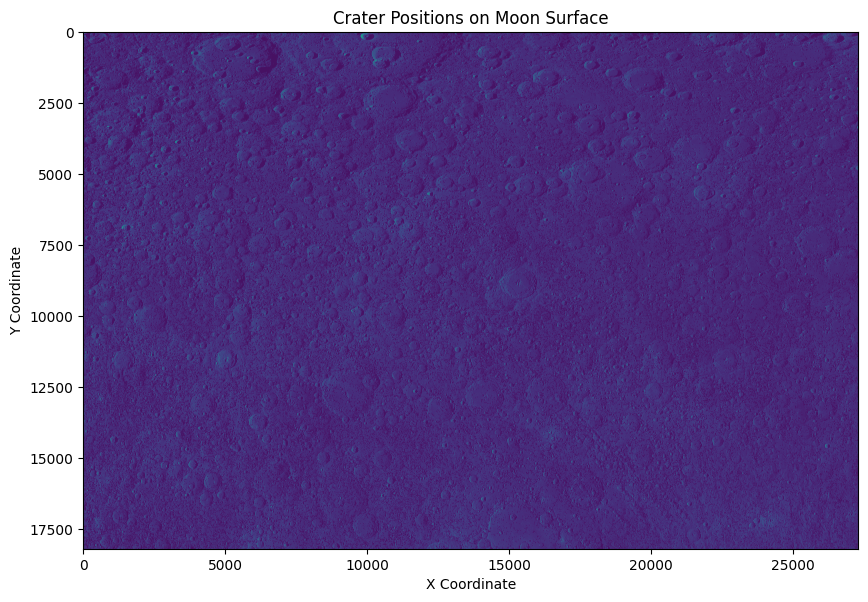

In [16]:
import rasterio
from rasterio.plot import show
import os

# Set the environment variable to ignore celestial body check
os.environ['PROJ_IGNORE_CELESTIAL_BODY'] = 'YES'

# Path to your image file
image_path = 'data/lro/WAC_GLOBAL_E300N2250_100M.IMG'

# Open the image with rasterio
with rasterio.open(image_path) as src:
    # Read the image data
    img_data = src.read(1)
    
    transform = src.transform
    crs = src.crs
    
    # Metadata for transformation
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)  # WGS84 to Moon Equirectangular
    
    # Convert crater positions to the equirectangular projection
    crater_positions_projected = df.apply(
    lambda row: transformer.transform(row['LON_ELLI_IMG'], row['LAT_ELLI_IMG']), axis=1
    )
    
    # Convert projected coordinates to pixel coordinates using the affine transform
    crater_pixels = crater_positions_projected.apply(lambda pos: ~transform * pos)
    
    
    crater_pixels_df = pd.DataFrame(crater_pixels.tolist(), columns=['x', 'y'])
    
    df.reset_index(drop=True, inplace=True)
    crater_pixels_df.reset_index(drop=True, inplace=True)

    df = pd.concat([df, crater_pixels_df], axis=1)
    
    df = df[(df['x'] < 0)]
    
    min_x = df['x'].min()
    
    df['x'] = df['x'] - min_x
    
    # df = df[df['DIAM_ELLI_MAJOR_IMG'] >= 50]
    
    for row in df.itertuples():
        x = int(row.x)
        y = int(row.y)
        major = int(row.DIAM_ELLI_MAJOR_IMG*10/2)
        minor = int(row.DIAM_ELLI_MINOR_IMG*10/2)
        rotation = int(row.DIAM_ELLI_ANGLE_IMG)
        
        rotation = np.radians(rotation)
        cv2.ellipse(img_data, (x, y),
                        (major, minor),
                        angle=rotation, startAngle=0, endAngle=360,
                        color=(0, 255, 0), thickness=5)
    
    # Get the image metadata
    metadata = src.meta

    # Print the metadata
    print("Metadata:", metadata)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_data)
    plt.title("Crater Positions on Moon Surface")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [18]:
# df = df[df['DIAM_ELLI_MAJOR_IMG'] >= 50]

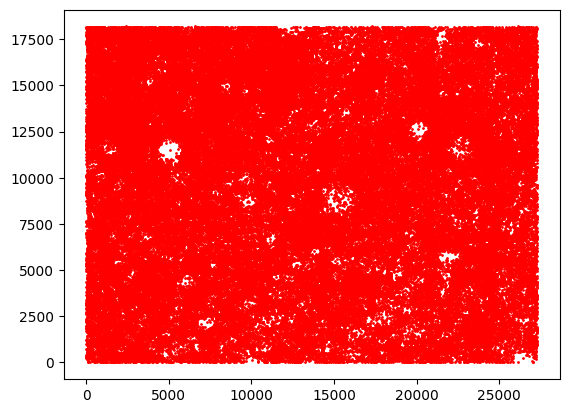

In [19]:
plt.scatter(df['x'], df['y'], c='red', s=1)

plt.show()

In [20]:
bl_corner_img = img_data[-5000:, :5000]

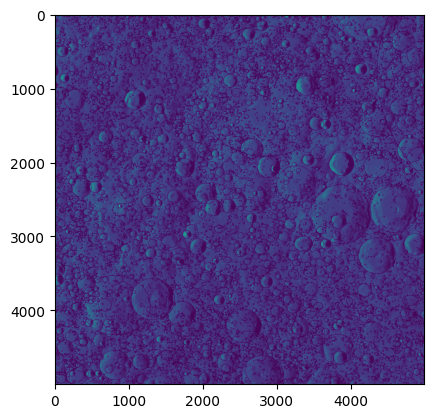

<Axes: >

In [21]:
show(bl_corner_img)

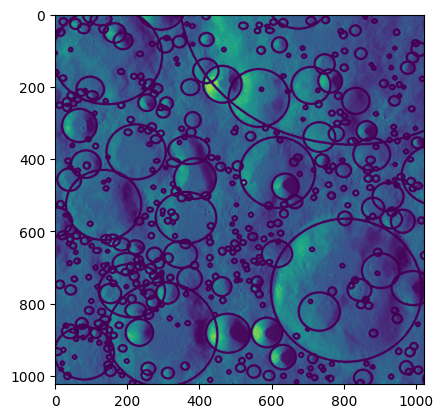

<Axes: >

In [22]:
bl_corner_img_2 = bl_corner_img[-1024:, :1024]
show(bl_corner_img_2)

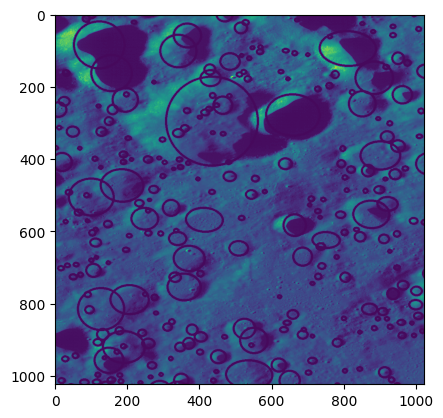

<Axes: >

In [23]:
bl_corner_img_3 = img_data[:1024, :1024]
show(bl_corner_img_3)

(26112, 2532)


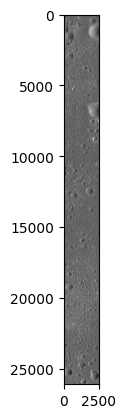

In [3]:
# Define image dimensions
height = 52224
width = 5064

# Load .IMG file
img_data = np.fromfile('data/lro/M1465577656LE.IMG', dtype=np.uint8)

# Calculate the expected size
expected_size = height * width

# Check if the data size matches the expected size
if img_data.size != expected_size:
    print(f"Warning: Data size ({img_data.size}) does not match expected size ({expected_size}). Trimming data.")
    img_data = img_data[img_data.size-expected_size:]

offset_left = 42
offset_right = 24
# Reshape array to image dimensions
img_data = img_data.reshape((height, width))
img_data = img_data[:, offset_left:-offset_right]

img_data = np.fliplr(img_data)

# Resize the image by half
img_data = cv2.resize(img_data, (width//2, height//2))

print(img_data.shape)
# Display the image
plt.imshow(img_data, cmap='gray')
plt.show()


In [16]:
img_data.shape

(26112, 2532)

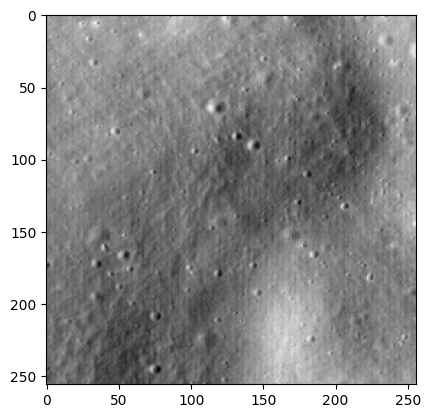

In [17]:
img_lt = Image.fromarray(img_data[:256, :256])

plt.imshow(img_lt, cmap='gray')
plt.show()

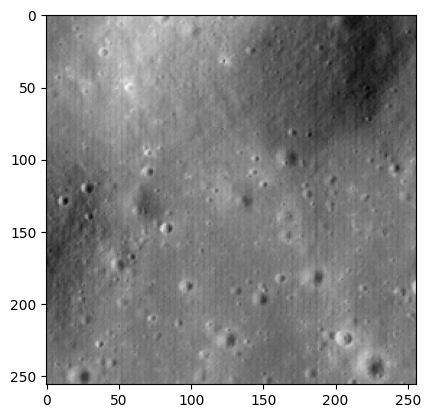

In [18]:
img_rt = Image.fromarray(img_data[:256, -256:])

plt.imshow(img_rt, cmap='gray')
plt.show()

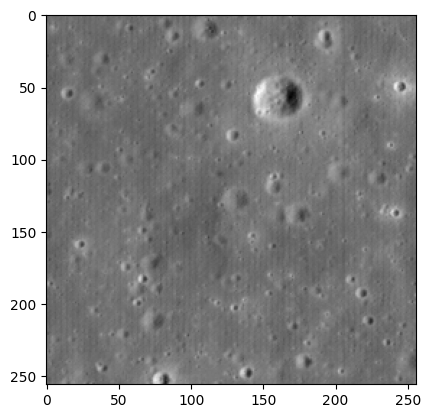

In [19]:
img_lb = Image.fromarray(img_data[-256:, :256])

plt.imshow(img_lb, cmap='gray')
plt.show()

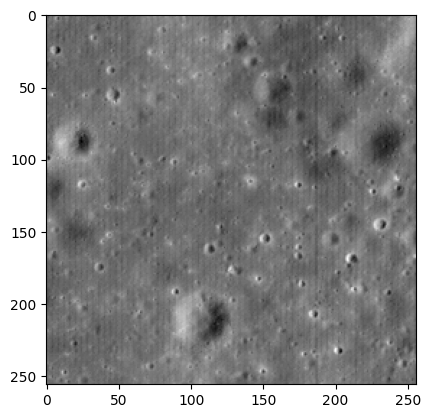

In [20]:
img_rb = Image.fromarray(img_data[-256:, -256:])

plt.imshow(img_rb, cmap='gray')
plt.show()

In [38]:

# Load the CSV file
df = pd.read_csv('./data/lunar_crater_database_robbins_2018.csv')
df.columns

Index(['CRATER_ID', 'LAT_CIRC_IMG', 'LON_CIRC_IMG', 'LAT_ELLI_IMG',
       'LON_ELLI_IMG', 'DIAM_CIRC_IMG', 'DIAM_CIRC_SD_IMG',
       'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ECCEN_IMG',
       'DIAM_ELLI_ELLIP_IMG', 'DIAM_ELLI_ANGLE_IMG', 'LAT_ELLI_SD_IMG',
       'LON_ELLI_SD_IMG', 'DIAM_ELLI_MAJOR_SD_IMG', 'DIAM_ELLI_MINOR_SD_IMG',
       'DIAM_ELLI_ANGLE_SD_IMG', 'DIAM_ELLI_ECCEN_SD_IMG',
       'DIAM_ELLI_ELLIP_SD_IMG', 'ARC_IMG', 'PTS_RIM_IMG'],
      dtype='object')

In [39]:
columns = ['LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG', 'LAT_ELLI_IMG', 'LON_ELLI_IMG', 'DIAM_ELLI_MAJOR_IMG', 'DIAM_ELLI_MINOR_IMG', 'DIAM_ELLI_ANGLE_IMG']

df = df.loc[:, columns]
df

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
0,-19.83040,264.7570,940.96000,-19.89050,264.6650,975.87400,905.96800,35.99190
1,44.77630,328.6020,249.84000,44.40830,329.0460,289.44000,245.78600,127.00300
2,57.08660,82.0995,599.77800,56.90000,81.6464,632.57100,561.43500,149.16200
3,1.96124,230.6220,558.76200,1.95072,230.5880,568.52900,546.37800,133.69100
4,-49.14960,266.3470,654.33200,-49.18330,266.3530,665.24000,636.57800,87.64680
...,...,...,...,...,...,...,...,...
1296791,-65.62580,203.5000,5.93636,-65.62160,203.5380,7.05088,5.88898,3.11966
1296792,-60.02960,178.7090,7.82310,-60.03010,178.7120,8.31388,7.45470,72.80650
1296793,-66.79210,219.3790,11.55320,-66.79510,219.3470,13.98770,9.96860,41.71070
1296794,-79.83740,62.1794,7.16411,-79.84080,62.1830,7.31069,6.53201,8.53317


In [40]:
df.describe()

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
count,1.296796e+06,1.296796e+06,1.296796e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06,1.296758e+06
mean,-1.317424e+00,1.664051e+02,2.436963e+00,-1.316777e+00,1.664043e+02,2.604695e+00,2.280037e+00,8.662636e+01
std,4.356372e+01,9.680522e+01,5.519133e+00,4.356387e+01,9.680489e+01,5.787466e+00,5.234790e+00,3.956002e+01
min,-8.984790e+01,5.172670e-04,1.000000e+00,-8.984790e+01,5.286540e-04,9.517580e-01,5.054060e-01,2.516500e-04
25%,-3.703373e+01,8.813620e+01,1.242710e+00,-3.703428e+01,8.813560e+01,1.326442e+00,1.160680e+00,6.162833e+01
50%,-3.664890e+00,1.594180e+02,1.606840e+00,-3.664035e+00,1.594170e+02,1.719435e+00,1.502360e+00,8.495685e+01
75%,3.326443e+01,2.386270e+02,2.380860e+00,3.326495e+01,2.386250e+02,2.553070e+00,2.228590e+00,1.102230e+02
max,8.997350e+01,3.600000e+02,2.491870e+03,8.997350e+01,3.600000e+02,2.612570e+03,2.373250e+03,1.800000e+02


/tmp/ipykernel_27124/682833293.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


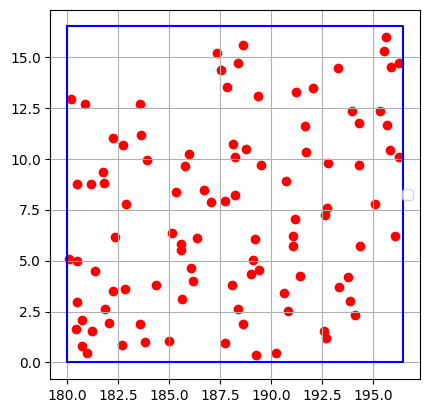

In [62]:

# #M1465577656LE
# polygon_vertices = [ # lon, lat. The order is important for the polygon to be closed ()
#     (0.82, 1.79),    # Upper right in LRO, upper left in the polygon
#     (0.94, 1.8),     # Upper left in LRO, upper right in the polygon
#     (1.07, 0.4),     # Lower left in LRO, lower right in the polygon 
#     (0.94, 0.39)     # Lower right in LRO, lower left in the polygon
# ]

# # M1467604114CE
# polygon_vertices = [ # lon, lat. The order is important for the polygon to be closed ()
#     (46.27, 13.35),    # Upper right in LRO, upper left in the polygon
#     (49.75, 13.71),     # Upper left in LRO, upper right in the polygon
#     (55.17, -30.82),     # Lower left in LRO, lower right in the polygon 
#     (50.76, -31.28)     # Lower right in LRO, lower left in the polygon
# ]

# # M1467582901RE
# polygon_vertices = [ # lon, lat. The order is important for the polygon to be closed ()
#     (50.03, 22.38),    # Upper right in LRO, upper left in the polygon
#     (50.18, 22.39),     # Upper left in LRO, upper right in the polygon
#     (50.24, 21.9),     # Lower left in LRO, lower right in the polygon 
#     (50.09, 21.88)     # Lower right in LRO, lower left in the polygon
# ]

# 5000x5000 global image
polygon_vertices = [ # lon, lat. The order is important for the polygon to be closed ()
    (180, 16.49),    # Upper right in LRO, upper left in the polygon
    (180 + 16.49, 16.49),     # Upper left in LRO, upper right in the polygon
    (180 + 16.49, 0),     # Lower left in LRO, lower right in the polygon 
    (180, 0)     # Lower right in LRO, lower left in the polygon
]


# Create a shapely Polygon object from the vertices
polygon = Polygon(polygon_vertices)


# Function to check if a point (crater) is within the polygon
def is_within_polygon(row):
    # ellipse_center = Point(row['LON_ELLI_IMG'], row['LAT_ELLI_IMG']) # x, y
    circle_center = Point(row['LON_CIRC_IMG'], row['LAT_CIRC_IMG']) # x, y
    
    return polygon.contains(circle_center)

filtered_df = df[df.apply(is_within_polygon, axis=1)]
filtered_df = filtered_df.sort_values('DIAM_CIRC_IMG', ascending=False).head(100)

fig, ax = plt.subplots()

# Get the x and y coordinates of the polygon
x, y = polygon.exterior.xy

# Plot the polygon
ax.plot(x, y, color='blue')

# Plot the filtered craters
ax.scatter(filtered_df['LON_CIRC_IMG'], filtered_df['LAT_CIRC_IMG'], color='red', marker='o')

# Add grid lines
ax.grid(True)

# Set aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add a legend
ax.legend()

# Show the plot
plt.show()


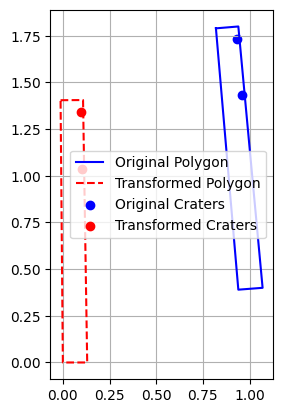

In [181]:

# Define the polygon vertices
polygon_vertices = [
    (0.82, 1.79),    # upper left in the polygon
    (0.94, 1.8),     # upper right in the polygon
    (1.07, 0.4),     # lower right in the polygon 
    (0.94, 0.39)     # lower left in the polygon
]

polygon_width = np.sqrt((polygon_vertices[0][0] - polygon_vertices[1][0])**2 + (polygon_vertices[0][1] - polygon_vertices[1][1])**2)
polygon_height = np.sqrt((polygon_vertices[1][0] - polygon_vertices[2][0])**2 + (polygon_vertices[1][1] - polygon_vertices[2][1])**2)

# Define the lower-left point
lower_left_point = np.array(polygon_vertices[3])
# Define the lower-right point
lower_right_point = np.array(polygon_vertices[2])

# Translation matrix to move lower-left point to the origin
translation_matrix = np.array([
    [1, 0, -lower_left_point[0]],
    [0, 1, -lower_left_point[1]],
    [0, 0, 1]
])

# Calculate the angle to rotate the polygon
delta_x = lower_right_point[0] - lower_left_point[0]
delta_y = lower_right_point[1] - lower_left_point[1]
theta = np.arctan2(delta_y, delta_x)

# Rotation matrix to align the vertical line with the y-axis
rotation_matrix = np.array([
    [np.cos(-theta), -np.sin(-theta), 0],
    [np.sin(-theta), np.cos(-theta), 0],
    [0, 0, 1]
])

# Combined transformation matrix
transformation_matrix = rotation_matrix @ translation_matrix 

# Transform the polygon vertices
def apply_transformation(point, matrix):
    homogeneous_point = np.array([point[0], point[1], 1])
    transformed_point = matrix @ homogeneous_point
    
    return (transformed_point[0], transformed_point[1])

original_craters_x = filtered_df['LON_ELLI_IMG']
original_craters_y = filtered_df['LAT_ELLI_IMG']

transformed_craters = [apply_transformation((x, y), transformation_matrix) for x, y in zip(original_craters_x, original_craters_y)]
transformed_vertices = [apply_transformation(vertex, transformation_matrix) for vertex in polygon_vertices]

# Create shapely Polygon objects
original_polygon = Polygon(polygon_vertices)
transformed_polygon = Polygon(transformed_vertices)

# Plot the original and transformed polygons
fig, ax = plt.subplots()

# Plot original polygon
x, y = original_polygon.exterior.xy
ax.plot(x, y, label='Original Polygon', color='blue')

# Plot transformed polygon
x, y = transformed_polygon.exterior.xy
ax.plot(x, y, label='Transformed Polygon', color='red', linestyle='--')

# Plot the original craters
ax.scatter(original_craters_x, original_craters_y, color='blue', marker='o', label='Original Craters')

# Plot the transformed craters
transformed_craters_x, transformed_craters_y = zip(*transformed_craters)
ax.scatter(transformed_craters_x, transformed_craters_y, color='red', marker='o', label='Transformed Craters')

# Set aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add a legend
ax.legend()

# Add grid
ax.grid(True)

# Show the plot
plt.show()


In [182]:
transformed_craters

[(np.float64(0.09559029790249762), np.float64(1.339353644401624)),
 (np.float64(0.10175508578635406), np.float64(1.0388657352615938))]

In [163]:
img_data.shape

(26112, 2532)

In [192]:
scale_factor_y = img_data.shape[0] / polygon_height
scale_factor_y

np.float64(18571.53436891585)

In [168]:
scale_factor_x = img_data.shape[1] / polygon_width
scale_factor_x

np.float64(21027.115498966963)

In [183]:
transformed_craters

[(np.float64(0.09559029790249762), np.float64(1.339353644401624)),
 (np.float64(0.10175508578635406), np.float64(1.0388657352615938))]

In [218]:
final_img = img_data.copy()
for i in transformed_craters:
    point_x, point_y = i
    x = int(point_x*scale_factor_x)
    y = int(img_data.shape[0] - point_y*scale_factor_y)
    print(x, y)
    cv2.circle(final_img, (x, y), radius=100, color=(255, 255, 255), thickness=-1)


2009 1238
2139 6818


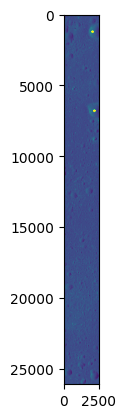

In [219]:
plt.imshow(final_img)

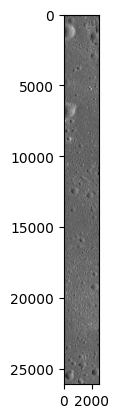

In [136]:
import cv2


src_shape = img_data.shape

# Resize the target image to a smaller size
target_img_resized = cv2.resize(img_data, (src_shape[1]//2, src_shape[0]//2))

plt.imshow(target_img_resized, cmap='gray')
plt.show()

In [131]:
filtered_df

,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ANGLE_IMG
562193,1.73277,0.932726,1.65217,1.73274,0.932585,1.71968,1.59330,106.322
562197,1.43358,0.961759,1.80851,1.43361,0.961778,1.88434,1.73084,140.175


In [129]:
list(zip(filtered_df['LON_ELLI_IMG'], filtered_df['LAT_ELLI_IMG']))

[(0.932585, 1.73274), (0.961778, 1.43361)]

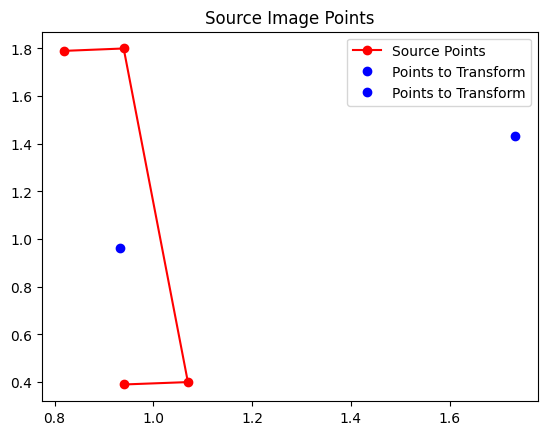

In [144]:
source_points = np.array(polygon_vertices, dtype=np.float32)
target_points = np.array([(target_img_resized_shape[1], target_img_resized_shape[0]), (0, target_img_resized_shape[0]), (0, 0), (target_img_resized_shape[1], 0)], dtype=np.float32)

# Estimate the perspective transformation matrix (M)
M = cv2.getPerspectiveTransform(source_points, target_points)

# Points in the source image
source_points_to_transform = np.array([list(zip(filtered_df['LON_ELLI_IMG'], filtered_df['LAT_ELLI_IMG']))], dtype=np.float32)

# Transform the points to get their corresponding points in the target image
target_points_transformed = cv2.perspectiveTransform(source_points_to_transform.reshape(-1, 1, 2), M)

# Plotting
plt.figure(figsize=(10, 5))

# Plot points in the source image
plt.subplot(1, 2, 1)
plt.plot(source_points[:, 0], source_points[:, 1], 'ro-', label='Source Points')
plt.plot(source_points_to_transform[:, 0], source_points_to_transform[:, 1], 'bo', label='Points to Transform')
plt.title('Source Image Points')
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.legend()

# Plot corresponding points in the target image
plt.subplot(1, 2, 2)
plt.plot(target_points[:, 0], target_points[:, 1], 'go-', label='Target Points')
plt.plot(target_points_transformed[:, 0, 0], target_points_transformed[:, 0, 1], 'bo', label='Transformed Points')
plt.title('Target Image Points (Transformed)')
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
src_pts = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])